# Варіант 2

# Загрузка і очищення даних

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("data/adult.data", header=None) # Загрузка данич
column_names = ['age', 'workclass', 'fnlwgt', 'education', 
                'education-num', 'marital-status', 'occupation', 
                'relationship', 'race', 'sex', 'capital-gain', 
                'capital-loss', 'hours-per-week', 'native-country', 'result'] # імені всіх колонок
string_column_names = ['workclass', 'education', 'marital-status', 'occupation', 
                'relationship', 'race', 'sex', 'native-country', 'result'] # імена всі колонок рядкового типу
def diff(li1, li2): 
    return (list(set(li1) - set(li2)))
numeric_column_names = diff(column_names, string_column_names) # імена всі колонок числового типу
df.columns = column_names
print(len(df))

32561


In [2]:
df.head() # перевіримо чи дані підгрузились

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  result  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

In [3]:
# Викинемо рядки, які містять пропущені дані
for name in df.columns: 
    if (any(df[name] == " ?")):
        df = df[df[name] != " ?"]

/home/username/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
# Перевіримо, скільки рядків було викинуто
print(len(df))

30162


# Попередня обробка даних

In [5]:
# Перетворимо категоріальні колонки у числові
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [6]:
# Перевіримо результат
fit_df = MultiColumnLabelEncoder(columns = string_column_names).fit_transform(df)
fit_df.head()

age  workclass  fnlwgt  education  education-num  marital-status  \
0   39          5   77516          9             13               4   
1   50          4   83311          9             13               2   
2   38          2  215646         11              9               0   
3   53          2  234721          1              7               2   
4   28          2  338409          9             13               2   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           0             1     4    1          2174             0   
1           3             0     4    1             0             0   
2           5             1     4    1             0             0   
3           5             0     2    1             0             0   
4           9             5     2    0             0             0   

   hours-per-week  native-country  result  
0              40              38       0  
1              13              38       0  
2              40              38       0  
3              40              38       0  
4              40               4       0

In [7]:
# Виберемо вхідні параметри і вихідний параметр
X = fit_df.loc[:, df.columns != 'result']
y = fit_df['result']

# Допоміжні функції

In [8]:
# Функція для виведення точності моделі
def estimate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mislabeled_num = (y_test != y_pred).sum()
    precision = 1.0 - (mislabeled_num/X_test.shape[0])
    error = np.mean(y_pred != y_test)
    print("Number of mislabeled points out of a total %d points: %d with precision: %f" % 
          (X_test.shape[0], mislabeled_num, precision))
    return precision, error

In [9]:
# Функція для аналізу ROC-кривої
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def roc(model, X_test, y_test):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Model (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
# Генерація всіх можливих підмножин із списку
def subsets(s):
    """
    :type s: list[]
    """
    sets = []
    for i in range(2**len(s)):
        subset = []
        for j in range(len(s)):
            if i & (1 << j) > 0:
                subset.append(s[j])
        sets.append(subset)
    return sets

# Наївний байесів класифікатор

In [ ]:
X_t

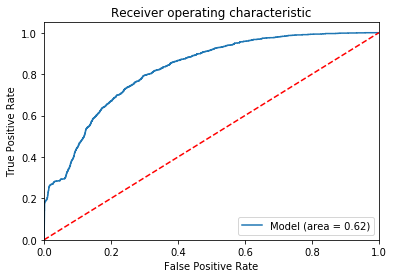

Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


(0.7856787667826952, 0.2143212332173048)

In [11]:
# Побудова 1 моделі
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data
gnb = GaussianNB()
model = gnb.fit(X_train, y_train)
roc(model, X_test, y_test)
estimate(model, X_test, y_test)

In [18]:
# Побудова всіх можливих моделей
cols = subsets(column_names[:-1])[1:] # формуємо всі підмножини колонок, окрім порожньої

In [19]:
# Цей код може працювати повільно, оскільки він створює багато моделей, кількість яких рівна 2^14 - 1, 
# адже ми перебираємо всі підмножини колонок, окрім порожної
precision = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data
for col in cols:
    X_train_i, X_test_i = X_train[col], X_test[col]
    gnb = GaussianNB()
    model = gnb.fit(X_train_i, y_train)
    print(col)
    prec, _ = estimate(model, X_test_i, y_test)
    precision.append(prec) # Зберігаємо точність моделей, щоб потім вибрати найкращу

['age']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870
['age', 'workclass']
Number of mislabeled points out of a total 6033 points: 1541 with precision: 0.744572
['fnlwgt']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'education']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'education']
Number of mislabeled points out of a 

In [21]:
# Знайдемо найгіршу модель
index = np.argmin(precision)
print("The worse model uses the following columns %s with precision %f" % (cols[index], precision[index]))

The worse model uses the following columns ['education', 'race', 'sex'] with precision 0.645782


In [22]:
# Виберемо найкращу із побудованих моделей
index = np.argmax(precision)
print("The best model uses the following columns %s with precision %f" % (cols[index], precision[index]))

The best model uses the following columns ['age', 'education-num', 'marital-status', 'hours-per-week'] with precision 0.822642


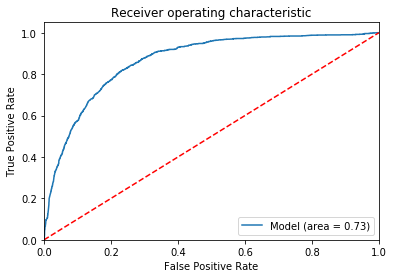

Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642


(0.8226421349245815, 0.17735786507541854)

In [25]:
 # Побудуємо найкращу модель ще раз
col = cols[index]
X_train_i, X_test_i = X_train[col], X_test[col]
gnb = GaussianNB()
model = gnb.fit(X_train_i, y_train)
roc(model, X_test_i, y_test)
estimate(model, X_test_i, y_test)

# Вибираємо лише числові колонки

In [26]:
X = fit_df[numeric_column_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # split data

# K-NN класифікатор

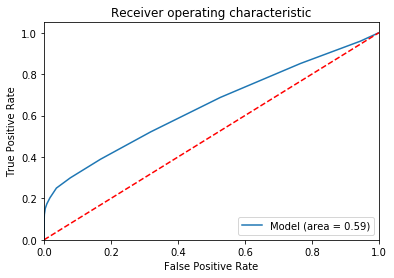

Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


(0.7884966020222112, 0.21150339797778883)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=14)
model.fit(X_train, y_train)
roc(model, X_test, y_test)
estimate(model, X_test, y_test)

In [28]:
error = []
precision = []
# Обчислюємо точність і помилки для k-NN моделей, для різних k від 1 до 40
for i in range(1, 40):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    y_pred_i = model.predict(X_test)
    
    # Зберагаємо оцінки моделей
    prec, err = estimate(model, X_test, y_test)
    precision.append(prec)
    error.append(err)    

Number of mislabeled points out of a total 6033 points: 1690 with precision: 0.719874
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
Number of mislabeled points out of a total 6033 points

In [29]:
# Знайдемо найгіршу модель
index = np.argmin(precision)
print("The worse model: with k = %d with precision %f" % (index + 1, precision[index]))

The worse model: with k = 1 with precision 0.719874


In [30]:
# Виберемо найкращу із побудованих моделей
index = np.argmax(precision)
print("The best model: with k = %d with precision %f" % (index + 1, precision[index]))

The best model: with k = 23 with precision 0.791812


Text(0, 0.5, 'Mean Error')

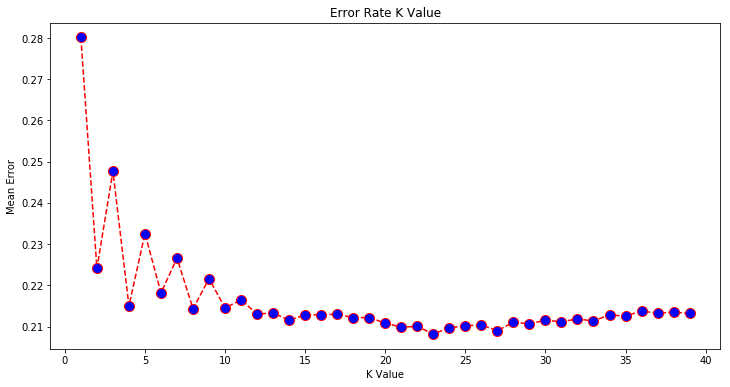

In [31]:
# Будуємо графік залежності помилки від k
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Text(0, 0.5, 'Precision')

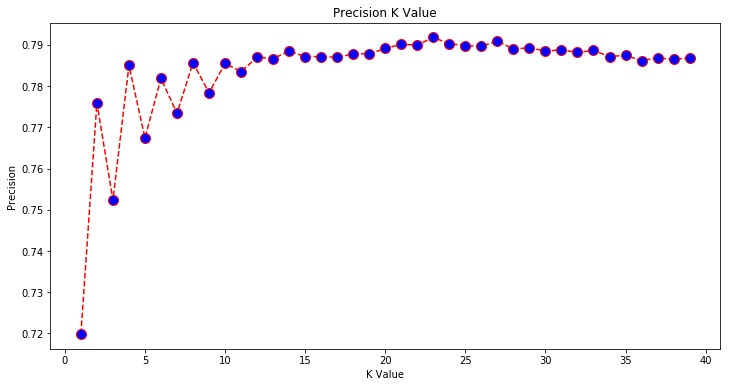

In [33]:
# Будуємо графік залежності точності від k
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), precision, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Precision K Value')
plt.xlabel('K Value')
plt.ylabel('Precision')

# Логістична регресія

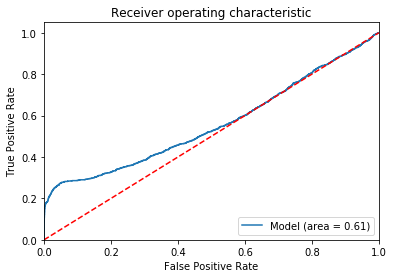

Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


(0.7875020719376761, 0.2124979280623239)

In [37]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, y_train)
roc(model, X_test, y_test)
estimate(model, X_test, y_test)

In [38]:
# Застереження: код працює повільно
# Цей код може працювати повільно, оскільки він створює багато моделей, кількість яких рівна 2^14 - 1, 
# адже ми перебираємо всі підмножини колонок, окрім порожної
# Логістична регресія із факторними даними
X = fit_df.loc[:, df.columns != 'result']
cols = subsets(column_names[:-1])[1:]

precision = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data
for col in cols:
    X_train_i, X_test_i = X_train[col], X_test[col]
    model = LogisticRegression(solver = 'lbfgs')
    model.fit(X_train_i, y_train)
    print(col)
    prec, _ = estimate(model, X_test_i, y_test)
    precision.append(prec)

['age']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621
['workclass']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289
['fnlwgt']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'education']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958
['workclass', 'education']
Number of mislabeled points out of a 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613
['

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Numb

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'marital-status', 'occupation', 'r

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['workclass', 'educa

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1226 with precision: 0.796784


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1448 with precision: 0.759987
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['age', 'occupation', 'capit

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['fnlwgt', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['age', 'education', 'education-num', 'occupation', 'capital-gain']
Number of misla

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['age', 'marital-status', 'occ

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'education', 'marital-status', 'occupation', 'capital-gain']
Number o

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['relationship', 'capital-gain']
Number of mislabeled points out of a total

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1154 with precision: 0.808719
['age', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045
['fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['education', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1159 with precision: 0.807890


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['age', 'marital-s

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1149 with precision: 0.809547


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1153 with precision: 0.808884


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['occupation', 'relationship', 'capital-gain']
Number of mislabel

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1152 with precisi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1165 with precision: 0.806895


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['education', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1288 with p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1130 with precision: 0.812697


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.78

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'education', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['workclass', 'fnlwgt', 'education', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['age', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['workclass', 'ed

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['fnlwgt', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['education', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['age', 'education', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'marital-status', 'race', 'capital-gain']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education', 'marital-statu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1226 with precision: 0.796784


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1457 with precision: 0.758495


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1260 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1268 with pr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1446 with precision: 0.760318


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['relationship', 'race', 'capital-g

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'workclass', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['fnlwgt', 'education', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['age', 'education-num', 'relationship', 'race', 'capita

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1085 with precision: 0.820156


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['workclass', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['education', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1149 with precision: 0.809547


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1213 with precision: 0.798939
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['occupation', 'relations

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1069 with precision: 0.822808


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['marital-status', 'occupation', 'relationshi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabele

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1090 with precision: 0.819327


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['fnlwgt', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['education', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['age', 'education', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['fnlwgt', 'education', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'education', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1167 with precision: 0.806564
['age', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1153 with precision: 0.808884


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['fnlwgt', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398
['age', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1150 wit

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled po

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1468 with precision: 0.756672
['fnlwgt', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1450 with precision: 0.759655
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1117 with precision: 0.814852


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1437 with precision: 0.761810
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1206 with precision: 0.800099


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precis

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['fnlwgt', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1167 with precision: 0.806564
['age', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1277 with precisio

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1532 with precision: 0.746063


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1471 with precision: 0.756174


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1417 with precision: 0.765125


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['relationship', 'sex', 'capital-gain']


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['age', 'education-num', 'relationship', 'sex', 'capital-gain'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1298 w

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a tot

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['occupation', 'relationship',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1059 wit

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['marital-status', 'occupation', 'relationship', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['fnlwgt', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['fnlwgt', 'education', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1150 with precision: 0.809382


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['fnlwgt', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1472 with precision: 0.756009


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1060 with precision: 0.824300
['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1119 with precision: 0.814520


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['education', 'marital-status', 'occupation', 'relationship', 'race', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1136 with precision: 0.811702


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1283 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['relationship', 'capital-loss']
Number of mislabeled points out of a total

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351
['age', 'marital-s

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['occupation', 'relationship', 'capital-loss']
Number of mislabel

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1541 with precision: 0.744572
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1548 with precision: 0.743411
['education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1485 with p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1550 with precision: 0.743080
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1540 with precision: 0.744737


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.75

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['education', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473
['age', 'ed

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1491 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1486 with pr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1609 with precision: 0.733300
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['relationship', 'race', 'capital-l

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1531 with precision: 0.746229
['fnlwgt', 'education', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'education-num', 'relationship', 'race', 'capita

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1543 with precision: 0.744240
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['education', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848
['age', 'educatio

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['occupation', 'relations

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['marital-status', 'occupation', 'relationshi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1542 with precision: 0.744406
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1541 with precision: 0.744572
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1548 with precision: 0.743411


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1543 with precision: 0.744240
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status', 'occ

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1550 with precision: 0.743080
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1553 with precision: 0.742582


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['age', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled po

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1623 with precision: 0.730980
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'education-num', 'marital-status', 'sex', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1493 with precis

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1550 with precisio

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1637 with precision: 0.728659
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['age', 'education', 'marital-statu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1669 with precision: 0.723355
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 poin

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1554 with precision: 0.742417


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1624 with precision: 0.730814
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['relationship', 'sex', 'capital-loss']


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1534 with precision: 0.745732
['workclass', 'education', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1546 with precision: 0.743743
['fnlwgt', 'education', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1195 with precision: 0.801923
['age', 'education-num', 'relationship', 'sex', 'capital-loss'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1206 with precision: 0.800099
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1484 w

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185
['age', 'education', 'm

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1631 with precision: 0.729654
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a tot

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['occupation', 'relationship',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1540 with precision: 0.744737
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1529 with precision: 0.746561


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1195 wit

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832
['marital-status', 'occupation', 'relationship', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1600 with precision: 0.734792
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1538 with precision: 0.745069
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909
['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled poin

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1523 with precision: 0.747555


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status', 'occupati

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1541 with precision: 0.744572


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['fnlwgt', 'education', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['age', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1431 with precision: 0.762805
['fnlwgt', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014
['age', 'marital-status'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1649 with precision: 0.726670
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1538 with precision: 0.745069


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621
['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1538 with precision: 0.745069


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267
['fnlwgt', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1556 with precision: 0.742085


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1612 with precision: 0.732803
['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1544 with precision: 0.744074


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1643 with precision: 0.727665


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1625 with precision: 0.730648


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Numb

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1550 with precision: 0.743080


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1437 with precision: 0.761810


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1534 with precision: 0.745732
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['fnlwgt', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235
['workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1540 with precision: 0.744737
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1236 with precision: 0.795127


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of misl

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1639 with precision: 0.728328
['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1542 with precision: 0.744406
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1481 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1627 with precision: 0.730317


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['education', 'education-num', 'marital-status', 'relat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1531 with precision: 0.746229


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1236 with precision: 0.795127


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1467 with precision: 0.756837


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['marital-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1576 with precision: 0.738770


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1540 with precision: 0.744737
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1543 with precision: 0.744240
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1549 with precision: 0.743245


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1217 with precision: 0.798276


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1550 with precision: 0.743080
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1554 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['education', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'marital-s

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950
['age', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950
['age', 'workclass', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'occupation', 'capital-gain', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['age', 'education-n

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1203 with precisi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1235 with p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1426 with precision: 0.763633


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'relationship', 'capital-gain', 'capital-loss']
Numbe

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1150 with precision: 0.809382
['age', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1153 with precision: 0.808884


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1150 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number o

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1155 with precision: 0.808553


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1195 with precision: 0.801923


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['age', 'education-num', 'race', 'capital-gain', 'capita

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 12

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1226 with precision: 0.796784


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'relationship

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045
['age', 'education-num', 'sex', 'capital-gain', 'capital-loss'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469
['fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116
['fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1410 with precision: 0.766285


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['occupation', 'sex', 'capital

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['education', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1155 with precision: 0.808553


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['marital-status', 'occupation', 'sex', 'capital-g

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1431 with precision: 0.762805


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1458 with precision: 0.758329


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'relationship', 's

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1226 with precision: 0.796784


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1171 with precision: 0.805901


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1236 with precision: 0.795127


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1154 with precision: 0.808719


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1170 with precision: 0.806067


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of m

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capita

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['hours-per-week']
Number of mislabeled points out of a total 6033 points: 1536 with precision: 0.745400
['age', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887
['workclass', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1534 with precision: 0.745732
['age', 'workclass', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887
['fnlwgt', 'hours-per-week']
Number of mislabeled points out of

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['relationship', 'race', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['occupation', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1525 with precision: 0.747224
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['relationship', 'sex', 'hours

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['occupation', 'rela

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1254 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of misl

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Nu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'marital-statu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Numb

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1213 with precision: 0.798939
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1532 with precision: 0.746063
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'marital-status', 'occupation', 'relationship'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.75

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-wee

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['fnlwgt', 'education', 'education-num', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['age'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'education', 'marital-status', 'capital-gain'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['fnlwgt', 'education', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517
['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1454 with precision: 0.758992
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['occupation', 'capital-gain', 'hours-per-week']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'education', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'workclass', 'education', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['fnlwgt', 'education', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1207 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1440 with precision: 0.761313


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number o

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1473 with precision: 0.755843


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1460 with precision: 0.757998
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 0.764628


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1448 with precision: 0.759987
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1127 with precision: 0.813194


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['age', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['age', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1127 with precision: 0.813194


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1090 with precision: 0.819327


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.77

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.78

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'education', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 po

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['fnlwgt', 'education', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['age', 'education-num', 'race', 'capital-ga

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1453 with precision: 0.759158


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['occupation', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1472 with precision: 0.756009


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1428 with precision: 0.763302
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1072 with precision: 0.822311


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1219 with precision: 0.797945


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relation

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1139 with precision: 0.811205


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 po

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142
['fnlwgt', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1473 with precision: 0.755843


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1426 with precision: 0.763633


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1457 with precision: 0.758495
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['occupation', 'sex'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['education', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1459 with precision: 0.758163


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1471 with precision: 0.756174


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1454 with precision: 0.758992


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['age', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1355 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.78

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1456 with precision: 0.758661


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 0.764628
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1431 with precision: 0.762805
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-wee

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1129 with precision: 0.812863


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1383 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1172 with precision: 0.805735


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.817669


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1172 with precision: 0.805735


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1213 with precision: 0.798939
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hou

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196
['age', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870
['workclass', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196
['age', 'workclass', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['fnlwgt', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['occupation', 'capital-loss', 'hours-per-week']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1519 with precision: 0.748218
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number o

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887
['fnlwgt', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1717 with precision: 0.715399
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status', 'occupation', 'capital-loss', 'hou

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1544 with precision: 0.744074
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1546 with precision: 0.743743
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['education', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1471 with precision: 0.756174
['age', 'education', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340
['workclass', 'education', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1465 with precision: 0.757169
['age', 'workclass', 'education', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1463 with precision: 0.757500
['fnlwgt', 'education', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'r

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['marital-status', 'relationship', 'capital-loss', 'hours-per-wee

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854
['fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1661 with precision: 0.724681
['education-num', 'marital-status', 'relationship', 'capital

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education', 'education-num', 'marital-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1217 with precision: 0.798276


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education', 'education-num', 'occupation', 'relationship',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1476 with precision: 0.755346
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1450 with precision: 0.759655
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378
['age', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1497 with precision: 0.751865


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1523 with precision: 0.747555
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education', 'marital-status', 'occupation', 'relation

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1522 with precision: 0.747721
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1567 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-pe

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['fnlwgt', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1523 with precision: 0.747555
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389
['age

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1670 with precision: 0.723189


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['occupation', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1497 with precision: 0.751865


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['workclass', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mis

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1609 with precision: 0.733300
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1551 with precision: 0.742914
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1520 with precision: 0.748052
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['marital-status', 'occupation', 'r

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1530 with precision: 0.746395


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1542 with precision: 0.744406
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1552 with precision: 0.742748


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1527 with precision: 0.746892


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education-num', 'marital-sta

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1650 with precision: 0.726504


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1448 with precision: 0.759987


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1625 with precision: 0.730648
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1549 with precision: 0.743245
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1546 with precision: 0.743743
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1547 with precision: 0.743577
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1531 with precision: 0.746229
['education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1473 with precision: 0.755843
['age', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1474 with precision: 0.755677
['workclass', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1460 with precision: 0.757998


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1464 with precision: 0.757335
['fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1548 with precision: 0.743411
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1549 with precision: 0.743245
['education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['marital-status', 'relat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196
['workclass', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1528 with precision: 0.746726
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1540 with precision: 0.744737


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1538 with precision: 0.745069


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1469 with precision: 0.756506


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1624 with precision: 0.730814
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1617 with precision: 0.731974
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1497 with precision: 0.751865


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabele

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1464 with precision: 0.757335


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1469 with precision: 0.756506
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1448 with precision: 0.759987


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1468 with precision: 0.756672


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1554 with precision: 0.742417
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1526 with precision: 0.747058


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1527 with precision: 0.746892


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1527 with precision: 0.746892
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036
['age', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['workclass', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['age', 'workclass', 'sex', 'capital-loss',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1464 with precision: 0.757335
['fnlwgt', 'education', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'fnlwgt', 'education', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'education-num', 'sex', 'capital-loss', 'h

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 po

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1532 with precision: 0.746063
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['occupation', 'sex'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1531 with precision: 0.746229
['fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389
['education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 poin

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1474 with precision: 0.755677


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1465 with precision: 0.757169
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1517 with precision: 0.748550
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['marital-status', 'occupation', 'sex', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1687 with precision: 0.720371


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mis

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1646 with precision: 0.727167
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'marital-status',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1676 with precision: 0.722195


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1622 with precision: 0.731145
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1621 with precision: 0.731311
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688
['age', 'relatio

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351
['fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a tot

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['marital-status', 'relationsh

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1556 with precision: 0.742085
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1519 with precision: 0.748218


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1466 with precision: 0.757003


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1213 with precision: 0.798939
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled poin

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1476 with precision: 0.755346


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1465 with precision: 0.757169
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1529 with precision: 0.746561
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1473 with precision: 0.755843


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1629 with precision: 0.729985


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['education', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1444 with precision: 0.760650


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Nu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1520 with precision: 0.748052


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1513 with precision: 0.749213


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1566 with precision: 0.740428


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1554 with precision: 0.742417


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1619 with precision: 0.731643
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1619 with precision: 0.731643


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1525 with precision: 0.747224


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1676 with precision: 0.722195


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1440 with precision: 0.761313


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1440 with precision: 0.761313


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1554 with precision: 0.742417
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1426 with precision: 0.763633


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1550 with precision: 0.743080


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1528 with precision: 0.746726


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1543 with precision: 0.744240


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1520 with precision: 0.748052
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1528 with precision: 0.746726


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1647 with precision: 0.727001
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1690 with precision: 0.719874


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1646 with precision: 0.727167


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.75

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1604 with precision: 0.734129


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1616 with precision: 0.732140


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1602 with precision: 0.734460


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1549 with precision: 0.743245
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1542 with precision: 0.744406
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688
['age', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['workclass', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185
['fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1466 with precision: 0.757003


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1458 with precision: 0.758329


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1548 with precision: 0.743411
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1618 with precision: 0.731808


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1544 with precision: 0.744074
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1223 with precision: 0.797282


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1223 with precision: 0.797282


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1616 with precision: 0.732140
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1474 with precision: 0.755677


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1444 with precision: 0.760650


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1463 with precision: 0.757500


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1520 with precision: 0.748052


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-stat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['marital-status', 'capital-gain', 'capital-loss', 'hours-per-wee

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1445 with precision: 0.760484


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['age', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1247 with p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.78

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1413 with precision: 0.765788


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1165 with precision: 0.806895


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1139 with precision: 0.811205


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-l

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['age', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precisio

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['age', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469
['age', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1148 with precision: 0.809713


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['age', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1134 with precision: 0.812034


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1130 with precision: 0.812697


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932
['fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1453 with precision: 0.759158


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1431 with precision: 0.762805


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1417 with precision: 0.765125


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1184 with precision: 0.803746


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 0.764628


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1417 with precision: 0.765125


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-stat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-pe

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hou

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'w

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'occupation', 'relationship', 'native-country']
Number o

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['relationship', 'race', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['occupation', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mis

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'occupation', 'r

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1623 with precision: 0.730980
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-sta

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['relationship', 'sex', 'nativ

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['occupation', 'rela

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabele

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'occupation', 'relati

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1536 with precision: 0.745400


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'nativ

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1643 with precision: 0.727665
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1627 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1621 with precision: 0.731311
['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1621 with precision: 0.731311


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1619 with precision: 0.731643
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-co

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'marital-status', 'occup

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'relationship', 'race', 'sex', 'native-country']
Nu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787
['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1539 with precision: 0.744903


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marital-status', 'relationship', 'race', 'sex'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'marital-statu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'occupation', 'relationship', 'rac

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1624 with precision: 0.730814
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'marital-status', 'occupation', 'relationship'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.75

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-countr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928
['fnlwgt', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'fnlwgt', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['education', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['age', 'education', 'education-num', 'capital-gain', 'nati

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['fnlwgt', 'education', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['fnlwgt', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with prec

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'workclass', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'occupation', 'cap

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['fnlwgt', 'education', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['fnlwgt', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1230 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['marital-status', 'occupation', 'capital-gain', 'native-country']
Number o

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['workclass', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['education-num', 'marital-status', 'occupation', 'capital-gain', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1400 with precision: 0.767943
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1426 with precision: 0.763633
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['workclass', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1154 with precision: 0.808

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['education', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1098 with precision: 0.818001


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1040 with precision: 0.827615


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-c

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['fnlwgt', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['workclass', 'fnlwgt', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['education', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'fnlwgt', 'education', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1206 with precision: 0.800099


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['fnlwgt', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1410 with precision: 0.766285


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['age', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['workclass', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['education', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['age', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['workclass', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['age', 'workclass', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['fnlwgt', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['ag

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1170 with precision: 0.806067


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['marital-status', 'relat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'fnlwgt', 'education', 'marital-status'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1119 with precision: 0.814520


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'marital-status', 'occup

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1187 with precision: 0.803249


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relation

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['fnlwgt', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1141 with precision: 0.810874


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['fnlwgt', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['education', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1167 with precision: 0.806564


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 po

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['workclass', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['fnlwgt', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['fnlwgt', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['education', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1206 with precision: 0.800099


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1223 with precision: 0.797282


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['workclass', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['fnlwgt', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['education', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'education', 'r

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a tot

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1155 with precision: 0.808553


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1117 with precision: 0.814852
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.817669


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1219 with precision: 0.797945


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['fnlwgt', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.77

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-countr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1055 with precision: 0.825128


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1159 with precision: 0.807890


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-stat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1596 with precision: 0.735455
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1556 with precision: 0.742085
['occupation', 'capital-loss', 'native-country']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1549 with precision: 0.743245
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['marital-status', 'occupation', 'capital-loss', 'native-country']
Number o

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1657 with precision: 0.725344
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['education-num', 'marital-status', 'occupation', 'capital-loss', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1638 with precision: 0.728493


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235
['education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351
['age', 'education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1530 with precision: 0.746395
['workclass', 'education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351
['age', 'workclass', 'education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1530 with precision: 0.746395
['fnlwgt', 'education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'r

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['fnlwgt', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['education', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['age', 'education', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1219 with precision: 0.797945


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['marital-status', 'relationship', 'capital-loss', 'native-countr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['education', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1555 with precision: 0.742251
['education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1458 with precision: 0.758329
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['fnlwgt', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1534 with precision: 0.745732
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588
['education-num', 'occupation', 'relationship', 'capital-loss', 'native-country'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881
['education', 'education-num', 'occupation', 'relationship',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.74

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1556 with precision: 0.742085


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1536 with precision: 0.745400


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1550 with precision: 0.743080
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-c

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919
['age', 'fnlwgt', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1566 with precision: 0.740428
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1566 with precision: 0.740428
['education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378
['fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1539 with precision: 0.744903
['fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588
['education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1551 with precision: 0.742914


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1613 with precision: 0.732637


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['occupation', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919
['education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588
['marital-status', 'occupation', 'r

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1530 with precision: 0.746395


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1658 with precision: 0.725178
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1551 with precision: 0.742914


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1611 with precision: 0.732969


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919
['fnlwgt', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1544 with precision: 0.744074
['fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['marital-status', 'relat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1541 with precision: 0.744572
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1541 with precision: 0.744572
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1444 with precision: 0.760650


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1536 with precision: 0.745400


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1530 with precision: 0.746395


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1566 with precision: 0.740428


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1555 with precision: 0.742251


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relation

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433
['education', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1497 with precision: 0.751865
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 po

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1527 with precision: 0.746892
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1551 with precision: 0.742914
['occupation', 'sex'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['fnlwgt', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['education', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517
['age', 'education', 'occupation', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1541 with precision: 0.744572
['fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 poin

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1517 with precision: 0.748550


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1460 with precision: 0.757998
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['marital-status', 'occupation', 'sex', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1612 with precision: 0.732803


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1613 with precision: 0.732637
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1526 with precision: 0.747058


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1472 with precision: 0.756009
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919
['fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588
['education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a tot

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['marital-status', 'relationsh

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1213 with precision: 0.798939


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1539 with precision: 0.744903
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['education', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled poin

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1532 with precision: 0.746063


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1547 with precision: 0.743577
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1603 with precision: 0.734295


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1517 with precision: 0.748550


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1548 with precision: 0.743411
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1566 with precision: 0.740428
['race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['fnlwgt', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['education', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688
['age', 'education', 'race', 'sex', 'capital-loss', 'native-country']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919
['education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1556 with precision: 0.742085
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1566 with precision: 0.740428
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Nu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1627 with precision: 0.730317


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1603 with precision: 0.734295
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['education', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1626 with precision: 0.730482


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1474 with precision: 0.755677


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1552 with precision: 0.742748
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1428 with precision: 0.763302


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1485 with precisi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1540 with precision: 0.744737
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1527 with precision: 0.746892


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1467 with precision: 0.756837
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1548 with precision: 0.743411


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1610 with precision: 0.733134


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1576 with precision: 0.738770
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1608 with precision: 0.733466


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1610 with precision: 0.733134


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1610 with precision: 0.733134
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.74

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1423 with precision: 0.764131


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1472 with precision: 0.756009
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1472 with precision: 0.756009


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-countr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1478 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1538 with precision: 0.745069


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1198 with precision: 0.801425


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1613 with precision: 0.732637


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1563 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1539 with precision: 0.744903


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1476 with precision: 0.755346


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1550 with precision: 0.743080
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1513 with precision: 0.749213


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1551 with precision: 0.742914


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1566 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-stat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['age', 'education', 'capital-gain', 'capital-loss', 'native-coun

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'workclass', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['workclass', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['workclass', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['education', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['age', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.78

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['education', 'marital-status', 'occupation', 'capital-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-c

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1150 with precision: 0.809382


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['workclass', 'marital-status', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['education', 'marital-status', 'relationship

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-countr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-l

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['marital-status', 'race'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['workclass', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['edu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1236 with precision: 0.795127
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capit

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 poin

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capit

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['educatio

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of m

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'workclass', 'fnlwgt', 'education'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1219 with precision: 0.797945


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of m

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-c

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relati

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1236 with precision: 0.795127
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235
['age', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1519 with precision: 0.748218
['workclass', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235
['age', 'workclass', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1522 with precision: 0.747721
['fnlwgt', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'hours-per-week', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'marital-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['occ

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'occup

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1236 with precision: 0.795127
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of m

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389
['fnlwgt', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'occupation'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['educatio

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1523 with precision: 0.747555
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['edu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['occupati

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['fnlwgt', 'education-num', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'marita

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['edu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.75

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1217 with precision: 0.798276


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047
['fnlwgt', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mis

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1473 with precision: 0.755843
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'occupation', 're

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1532 with precision: 0.746063
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['educatio

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1536 with precision: 0.745400
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of m

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'rela

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['marital-status', 'race', 'sex', 'hours-per-week', 'native-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'mar

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1525 with precision: 0.747224
['fnlwgt', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1531 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-co

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'education-num', 'occupation', 'race', 's

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'marital-status', 'occupation', 'rac

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1538 with precision: 0.745069


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1476 with precision: 0.755346
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education-num', 'relationship', 'race', 'sex', 'hours-per-week'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['workclass', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1526 with precision: 0.747058
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-w

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['education', 'occupation', 'relationship', 'race', 'sex', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.75

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-countr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1544 with precision: 0.744074


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1531 with precision: 0.746229
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-c

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'mari

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['fnlwgt', 'education', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'fnlwgt', 'education', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['workclass', 'fnlwgt', 'education', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['age', 'workclass', 'fnlwgt', 'education', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1198 with precision: 0.801425
['age', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['fnlwgt', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['age', 'fnlwgt', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['fnlwgt', 'education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['fnlwgt', 'education', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1426 with precision: 0.763633


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['fnlwgt', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'fnlwgt', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1417 with precision: 0.765125


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1400 with precision: 0.767943
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['fnlwgt', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['fnlwgt', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['workclass', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'fnlwgt', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['workclass', 'education', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'education', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'fnlwgt', 'education', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.77

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-countr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1410 with precision: 0.766285


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of m

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'fnlwgt',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['fnlwgt', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['workclass', 'fnlwgt', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['fnlwgt', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['fnlwgt', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.77

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1413 with precision: 0.765788


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['fnlwgt', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1154 with precision: 0.808719


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.77

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-c

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'fnlwgt', 'education', 'education-num

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['age', 'fnlwgt', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1601 with precision: 0.734626
['workclass', 'fnlwgt', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1602 with precision: 0.734460
['education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['fnlwgt', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'fnlwgt', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['workclass', 'fnlwgt', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1602 with precision: 0.734460
['marital-status', 'capital-loss', 'hours-per-week', 'n

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898
['fnlwgt', 'education', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'fnlwgt', 'education', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['education-num', 'marital-status', 'capital-loss'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1450 with precision: 0.759655
['fnlwgt', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1522 with precision: 0.747721
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533
['workclass', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'workclass', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357
['fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['education-num', 'occupation', 'capital-loss', 'hours-per-week', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566
['fnlwgt', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['education', 'education-num', 'occupation', 'capi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1528 with precision: 0.746726


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1555 with precision: 0.742251
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1522 with precision: 0.747721
['fnlwgt', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['education', 'marital-status', 'occupation',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1413 with precision: 0.765788


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1617 with precision: 0.731974


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1603 with precision: 0.734295


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1554 with precision: 0.742417


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1638 with precision: 0.728493


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1608 with precision: 0.733466


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1602 with precision: 0.734460
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688
['age', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['workclass', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'workclass', 'relationship', 'capital-loss', 'hours-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1471 with precision: 0.756174
['workclass', 'education', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1467 with precision: 0.756837


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1454 with precision: 0.758992
['fnlwgt', 'education', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'fnlwgt', 'education', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['education-num', 'relationship', 'capital-loss', 'hours-per

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965
['fnlwgt', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['education', 'marital-status', 're

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1474 with precision: 0.755677


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1596 with precision: 0.735455
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['workclass', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357
['fnlwgt', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1602 with precision: 0.734460


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1528 with precision: 0.746726
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958
['education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1530 with precision: 0.746395
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-c

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1536 with precision: 0.745400
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1448 with precision: 0.759987
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621
['race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['age', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533
['workclass', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870
['age', 'workclass', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['fnlwgt', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['fnlwgt', 'education', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1576 with precision: 0.738770
['age', 'fnlwgt', 'education', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'education', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['workclass', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['fnlwgt', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1601 with precision: 0.734626
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1605 with precision: 0.733963
['education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1550 with precision: 0.743080
['fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1602 with precision: 0.734460
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['marital-statu

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['fnlwgt', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'fnlwgt', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['education', 'marital-status', 'race', 'capital-loss', 'hours-per-week', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1544 with precision: 0.744074


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1523 with precision: 0.747555
['fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1455 with precision: 0.758826


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1525 with precision: 0.747224
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1620 with precision: 0.731477


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1566 with precision: 0.740428
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of m

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['fnlwgt', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870
['age', 'fnlwgt', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1452 with precision: 0.759324
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1552 with precision: 0.742748


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1524 wi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1539 with precision: 0.744903


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1544 with precision: 0.744074


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1613 with precision: 0.732637
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1517 with precision: 0.748550


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1523 with precision: 0.747555


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1548 with precision: 0.743411


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1534 with precision: 0.745732
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1550 with precision: 0.743080
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1556 with precision: 0.742085


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1607 with precision: 0.733632


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['workclass', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['fnlwgt', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1472 with precision: 0.756009


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1471 with precision: 0.756174


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1463 with precision: 0.757500


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683
['fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['education-num', 'r

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-countr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1527 with precision: 0.746892
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1523 with precision: 0.747555


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1460 with precision: 0.757998


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1437 with precision: 0.761810


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1431 with precision: 0.762805


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of m

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1522 with precision: 0.747721
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'r

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1608 with precision: 0.733466
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1458 with precision: 0.758329
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848
['workclass', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1497 with precision: 0.751865
['age', 'workclass', 'sex', 'capital-lo

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1458 with precision: 0.758329
['fnlwgt', 'education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604
['age', 'fnlwgt', 'education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1604 with precision: 0.734129


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1467 with precision: 0.756837
['fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['marital-status', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1554 with precision: 0.742417
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1519 with precision: 0.748218


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1617 with precision: 0.731974
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1551 with precision: 0.742914
['education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1473 with precision: 0.755843
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.73

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['workclass', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1571 with precision: 0.739599
['fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['education', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mis

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['education-num', 'occupation', 'se

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1544 with precision: 0.744074
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1532 with precision: 0.746063


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1529 with precision: 0.746561


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1469 with precision: 0.756506


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1600 with precision: 0.734792


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1612 with precision: 0.732803


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1614 with precision: 0.732471


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1523 with precision: 0.747555


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1472 with precision: 0.756009


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1522 with precision: 0.747721
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1520 with precision: 0.748052
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1426 with precision: 0.763633


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1622 with precision: 0.731145


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1458 with precision: 0.758329


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185
['fnlwgt', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1454 with precision: 0.758992


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1459 with precision: 0.758163


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['education-num', 'relati

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1223 with precision: 0.797282


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1426 with precision: 0.763633
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1566 with precision: 0.740428
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1519 with precision: 0.748218
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1538 with precision: 0.745069


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1548 with precision: 0.743411
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationsh

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1474 with precision: 0.755677


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1468 with precision: 0.756672


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1219 with precision: 0.797945


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1596 with precision: 0.735455


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'ca

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1458 with precision: 0.758329
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1497 with precision: 0.751865


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1497 with precision: 0.751865


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909
['fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['age', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['education', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 p

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1576 with precision: 0.738770
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533
['fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1605 with precision: 0.733963


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1467 with precision: 0.756837
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1601 with precision: 0.734626


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1609 with precision: 0.733300


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1601 with precision: 0.734626


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1572 with precision: 0.739433


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1476 with precision: 0.755346


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1456 with precision: 0.758661


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1611 with precision: 0.732969


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1565 with precision: 0.740593
['fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1578 with precision: 0.738439
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.73

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1534 with precision: 0.745732
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1605 with precision: 0.733963


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1596 with precision: 0.735455


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1596 with precision: 0.735455


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1603 with precision: 0.734295
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-c

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1466 with precision: 0.757003


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1547 with precision: 0.743577


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1456 with precision: 0.758661


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1534 with precision: 0.745732
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with precision: 0.736781
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1497 with precision: 0.751865


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1608 with precision: 0.733466


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1560 with precision: 0.741422


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1568 with precision: 0.740096
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'mari

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699
['fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1580 with precision: 0.738107


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1590 with precision: 0.736450


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1520 with precision: 0.748052


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1599 with preci

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1468 with precision: 0.756672


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1527 with precision: 0.746892


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1531 with precision: 0.746229
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1513 with precision: 0.749213


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1589 with precision: 0.736615
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1588 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1497 with precision: 0.751865


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1527 with precision: 0.746892


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1536 with precision: 0.745400
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1584 with precision: 0.737444


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1597 with precision: 0.735289


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1534 with precision: 0.745732


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1518 with precision: 0.748384


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1583 with precision: 0.737610
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1600 with precision: 0.734792


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1532 with precision: 0.746063
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1591 with precision: 0.736284
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Num

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['workclass', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['age', 'workclass', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['age', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['age', 'fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision:

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'nat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'h

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education', 'education-num', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-w

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'workclass', 'fnlwgt', 'education', 'education

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-countr

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occ

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precisio

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of m

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
N

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'cap

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['age', 'workclass', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['age', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a tota

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislab

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'ed

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled point

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', '

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 603

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation',

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-w

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupat

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'h

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.7

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupati

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age'

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657


/home/username/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1321 with precision: 0.781038
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled poi

In [41]:
# Знайдемо найгіршу модель
index = np.argmin(precision)
print("The worse model uses the following columns %s with precision %f" % (cols[index], precision[index]))

The worse model uses the following columns ['marital-status', 'sex'] with precision 0.712912


In [42]:
# Виберемо найкращу із побудованих моделей
index = np.argmax(precision)
print("The best model uses the following columns %s with precision %f" % (cols[index], precision[index]))

The best model uses the following columns ['education-num', 'occupation', 'relationship', 'capital-gain', 'native-country'] with precision 0.827615


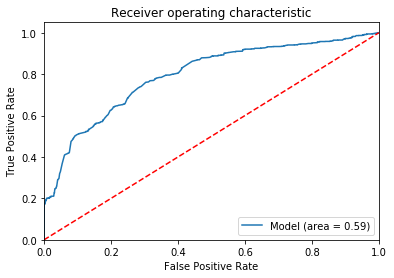

Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845


(0.7858445217967843, 0.21415547820321565)

In [43]:
# Побудуємо найкращу модель ще раз
col = cols[index]
X_train_i, X_test_i = X_train[col], X_test[col]
gnb = GaussianNB()
model = gnb.fit(X_train_i, y_train)
roc(model, X_test_i, y_test)
estimate(model, X_test_i, y_test)

# Kaggle spam

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("data/kaggle_spam.csv") # Завантаження даних

In [45]:
df.head()

Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

In [46]:
# Підготовка даних
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
df['Category'] = LabelEncoder().fit_transform(df['Category'])
y = df['Category']
X = df['Message']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data

In [47]:
# Векторизуємо колонку із повідомленнями, тобто рахуємо частоту використання слів
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

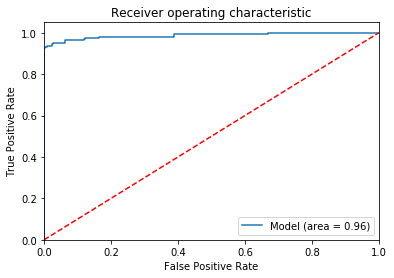

Number of mislabeled points out of a total 1115 points: 15 with precision: 0.986547


(0.9865470852017937, 0.013452914798206279)

In [48]:
# Побудова моделі
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
model = mnb.fit(X_train_counts, y_train)
roc(model, X_test_counts, y_test)
estimate(model, X_test_counts, y_test)